# Imports and function definitions

In [14]:
!source activate /home/gilbee3/anaconda3/envs/akita

In [15]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from cooltools.lib.numutils import set_diag

In [16]:
from scipy.spatial.distance import jaccard
from sklearn import metrics

In [17]:
# vector_repr is the non-index columns of the individual results mats
# matrix_len is the size of the symmetric matrix == 448 for default length regions
# diagonal offset for preds, set as 2 in the examples
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

def plot_one(vec, subplt, name, num_pairs):
# plot pred
    plt.subplot(num_pairs,2,subplt) 
    vmin=-2; vmax=2
    mat = from_upper_triu(vec, 448, 2)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+name,y=1.15 )


def pair_of_plots(vec1, vec2, ind1, ind2, subplt, num_pairs):
    plot_one(vec1, subplt[0], ind1, num_pairs)
    plot_one(vec2, subplt[1], ind2, num_pairs)

def plot_top_off_diag(df1, df2, idxs, ind1,ind2, num_pairs):
    plt.subplots(num_pairs,2, figsize=(8,(8*num_pairs)))
    vmin=-2; vmax=2
    subplt= np.array([1,2])
    for loc in idxs:
        vec1 = df1.loc[loc]
        vec2 = df2.loc[loc]
        pair_of_plots(vec1, vec2, str(ind1 + str(loc)), str(ind2 + str(loc)), subplt, num_pairs)
        subplt += 2
        
def read_ind_3dpreds(indname):
    df = pd.read_table('/dors/capra_lab/users/evonne/nean_3d/comparisonsPairwise/data/harmonized/3dpredsPerIndiv/3dpreds_'+indname+'.txt.gz'
                       , header=None)
    df=df.rename(columns={0: "chr", 1: "pos"})
    df = df.set_index(['chr','pos'])
    return df

def find_diff_pairs(ind1, ind2, m1, m2, label):
    findDiff = pairs[(ind1,ind2)]
    findDiff[label] = np.abs(findDiff[m1] - findDiff[m2])
    diff=findDiff.sort_values(by=label,ascending=False)[['chr','windowStartPos',m1,m2,label]].head(10)
    return diff

# Read in pairwise comparisons

In [134]:
AFR_ESN_female_HG03105 = read_ind_3dpreds('AFR_ESN_female_HG03105')

KeyboardInterrupt: 

In [ ]:
altai=read_ind_3dpreds('altai')

In [18]:
# Read in the pairwise comparisons between harmonized individuals

coverage = pd.read_csv("/dors/capra_lab/users/evonne/nean_3d/comparisonsPairwise/data/harmonized/coveragePerIndiv/coverage_AFR_GWD_female_HG03539.txt.gz",sep="\t",header=None)
coverage.columns= ['chr','windowStartPos','coverage','masked_coverage']
regionsToKeep = coverage[coverage['coverage'] == 1][['chr','windowStartPos']]
len(regionsToKeep) # only keep regions with full coverage in 1kg!!

4999

In [19]:
# This takes a few minutes
indivs = ['chagyrskaya', 'denisova', 'altai' ,'vindija','AFR_ESN_female_HG03105', 'AFR_GWD_female_HG03539', 'AFR_LWK_female_NA19378', 'AFR_MSL_female_HG03212', 'AFR_YRI_female_NA18870', 'AFR_YRI_female_NA19159', 'EAS_CDX_female_HG00978', 'EAS_CHB_female_NA18595', 'EAS_CHS_female_HG00560', 'EAS_JPT_female_NA19077', 'EAS_KHV_female_HG01851', 'EUR_CEU_female_NA12006', 'EUR_FIN_female_HG00285', 'EUR_GBR_female_HG00261', 'EUR_IBS_female_HG01519', 'EUR_TSI_female_NA20795']
pairs = {}
for i1 in indivs:
    print(i1)
    for i2 in indivs:
        try:
            pair = pd.read_csv("/dors/capra_lab/users/evonne/nean_3d/comparisonsPairwise/data/harmonized/pairwiseComparisons/3dcomp_%s_vs_%s.txt.gz" % (i1,i2),sep="\t")
            coverage1 = pd.read_csv("/dors/capra_lab/users/evonne/nean_3d/comparisonsPairwise/data/harmonized/coveragePerIndiv/coverage_%s.txt.gz" % i1,sep="\t",header=None)
            coverage1.columns = ['chr','windowStartPos','%s_coverage'% i1,'masked_coverage']
            coverage2 = pd.read_csv("/dors/capra_lab/users/evonne/nean_3d/comparisonsPairwise/data/harmonized/coveragePerIndiv/coverage_%s.txt.gz" % i2,sep="\t",header=None)
            coverage2.columns = ['chr','windowStartPos','%s_coverage'% i2,'masked_coverage']
            pair = pair.merge(coverage1).merge(coverage2)
            pair = regionsToKeep.merge(pair, how='inner',on=['chr','windowStartPos']) # only keep windows with full coverage in 1kg
            pairs[(i1,i2)] = pair
        except FileNotFoundError:
            pass


len(pairs) # should be 190 when all pair-wise comparisons are finished

chagyrskaya
denisova
altai
vindija
AFR_ESN_female_HG03105
AFR_GWD_female_HG03539
AFR_LWK_female_NA19378
AFR_MSL_female_HG03212
AFR_YRI_female_NA18870
AFR_YRI_female_NA19159
EAS_CDX_female_HG00978
EAS_CHB_female_NA18595
EAS_CHS_female_HG00560
EAS_JPT_female_NA19077
EAS_KHV_female_HG01851
EUR_CEU_female_NA12006
EUR_FIN_female_HG00285
EUR_GBR_female_HG00261
EUR_IBS_female_HG01519
EUR_TSI_female_NA20795


190

In [20]:
# Now you have a dictionary of all genomewide 1 Mb pairwise comparisons, for example between altai & chagy neanderthals:
pairs[('altai','chagyrskaya')].head()

chr  windowStartPos       mse  spearman  triangle_mse  triangle_spearman  \
0  chr1          524288  0.000049  0.999901  4.745326e-06           0.999922   
1  chr1         1048576  0.000028  0.999948  1.799373e-06           0.999985   
2  chr1         1572864  0.000219  0.999428  3.506708e-05           0.999574   
3  chr1         4194304  0.000144  0.997310  2.901225e-05           0.998961   
4  chr1         4718592  0.000016  0.999753  8.135833e-07           0.999812   

   insulation_spearman  altai_coverage  masked_coverage  chagyrskaya_coverage  
0             0.999617        0.445566         0.443856              0.445396  
1             0.999688        0.570948         0.569921              0.570571  
2             0.998922        0.644570         0.643854              0.644262  
3             0.997824        0.751499         0.751086              0.751260  
4             0.999144        0.762431         0.762168              0.762219

# Plot Distributions

In [8]:
comp = pairs[('AFR_ESN_female_HG03105','altai')]

In [9]:
comp.to_csv('AFR_ESN_female_HG03105_vs_altai_metriccomps.txt', sep='\t', index=False)

(0.95, 1.0)

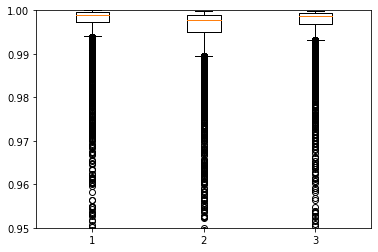

In [44]:
plt.boxplot([comp.triangle_spearman, comp.insulation_spearman, comp.spearman], autorange=True);
plt.ylim(.95,1)

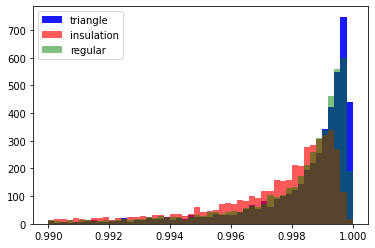

In [45]:
plt.hist(comp.triangle_spearman, bins=50, range=[.99,1], alpha=0.9, color='b', label='triangle')
plt.hist(comp.insulation_spearman, bins=50, range=[.99,1], alpha=0.65, color='r', label='insulation')
plt.hist(comp.spearman, bins=50, range=[.99,1], alpha=0.5, color='g', label='regular')
plt.legend(loc='best');

# Correlation Thresholds (Percentile)

## Set up thresholds and percentiles

In [46]:
sp = []
tsp = []
isp = []
for t in np.arange(0, 1.0, 0.01).round(decimals=2):
    comp[str('sp_' + str(t))] = comp.spearman < comp.spearman.quantile(q=t)
    comp[str('tsp_' + str(t))] = comp.triangle_spearman < comp.triangle_spearman.quantile(q=t)
    comp[str('isp_' + str(t))] = comp.insulation_spearman < comp.insulation_spearman.quantile(q=t)

In [137]:
comp.spearman.quantile(.1)

0.9919560622210715

In [88]:
tsp_diff = set(comp[comp['tsp_0.1']].index)
isp_diff = set(comp[comp['isp_0.1']].index)

sp_sets = []
for perc in np.arange(0.01, 0.21, 0.01).round(decimals=2):
    sp_sets.append(set(comp[comp[str('sp_' + str(perc))]].index))

## Identify regions not called by regular spearman

### Triangle

In [124]:
tsp_missing = []
for s in sp_sets:
    tsp_missing.append(comp.loc[tsp_diff-s].sort_values(by = ['spearman'], ascending=False))

In [125]:
percs = np.arange(0.01, 0.21, 0.01).round(decimals=2)

In [126]:
tsps = []
for i in tsp_missing:
    tsps.append(i.triangle_spearman)

In [127]:
percs

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

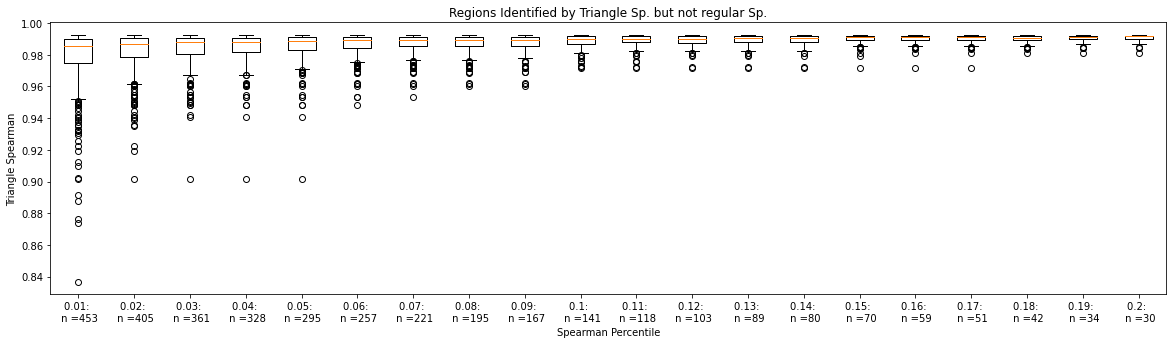

In [130]:
tsp_dict = {}
for i in range(20):
    leng = tsps[i].shape[0]
    name = str(str(percs[i]) + ': \n n =' + str(leng))
    tsp_dict[name] = tsps[i]
    
fig, ax = plt.subplots(figsize=(20,5))
ax.boxplot(tsp_dict.values())
ax.set_title('Regions Identified by Triangle Sp. but not regular Sp.')
ax.set_xlabel('Spearman Percentile')
ax.set_ylabel('Triangle Spearman')
ax.set_xticklabels(tsp_dict.keys());

#### Specific regions

In [133]:
tsp_missing[19]

chr  windowStartPos       mse  spearman  triangle_mse  \
3765  chr14        38797312  0.000274  0.998406      0.000038   
2569   chr8        88604672  0.000226  0.998404      0.000034   
3342  chr12        13631488  0.000311  0.998321      0.000039   
4370  chr18        38797312  0.000437  0.998287      0.000075   
4023  chr15        95944704  0.000066  0.998160      0.000006   
665    chr2       158859264  0.000245  0.998019      0.000036   
1598   chr5        45088768  0.000195  0.997888      0.000017   
2100   chr6       144703488  0.000133  0.997877      0.000041   
3659  chr13        74973184  0.000150  0.997680      0.000032   
3677  chr13        84410368  0.000057  0.997494      0.000007   
819    chr3         1048576  0.000036  0.997075      0.000005   
1883   chr6        23592960  0.000433  0.996999      0.000048   
1269   chr4        60293120  0.000168  0.996985      0.000010   
1971   chr6        74973184  0.000087  0.996861      0.000011   
4940   chrX       120586240  0.000026  0.996794      0.000003   
3155  chr11        37748736  0.000048  0.996704      0.000006   
973    chr3        84934656  0.000549  0.996582      0.000081   
3716  chr13       105906176  0.000069  0.996560      0.000014   
3879  chr14        98566144  0.000126  0.996527      0.000015   
3914  chr15        36175872  0.000115  0.996518      0.000013   
3744  chr14        27787264  0.000237  0.996475      0.000039   
603    chr2       124780544  0.000131  0.996429      0.000013   
4850   chrX        66584576  0.000313  0.996394      0.000036   
1734   chr5       123207680  0.000150  0.996335      0.000025   
82     chr1        49807360  0.000050  0.996201      0.000007   
3237  chr11        90177536  0.000070  0.996183      0.000009   
4905   chrX        98566144  0.000054  0.996178      0.000009   
694    chr2       174063616  0.000993  0.996089      0.000093   
2661   chr8       136839168  0.000396  0.996088      0.000061   
1330   chr4        93323264  0.000065  0.996065      0.000009   

      triangle_spearman  insulation_spearman  AFR_ESN_female_HG03105_coverage  \
3765           0.985175             0.994609                              1.0   
2569           0.989702             0.991486                              1.0   
3342           0.992586             0.995214                              1.0   
4370           0.989190             0.997864                              1.0   
4023           0.992338             0.991848                              1.0   
665            0.990401             0.989621                              1.0   
1598           0.992200             0.977026                              1.0   
2100           0.991666             0.994760                              1.0   
3659           0.991999             0.994085                              1.0   
3677           0.991513             0.993722                              1.0   
819            0.991933             0.992332                              1.0   
1883           0.991367             0.989309                              1.0   
1269           0.991927             0.996231                              1.0   
1971           0.992565             0.998045                              1.0   
4940           0.991908             0.989853                              1.0   
3155           0.990025             0.991939                              1.0   
973            0.984239             0.993531                              1.0   
3716           0.991590             0.979777                              1.0   
3879           0.986651             0.982598                              1.0   
3914           0.989480             0.990236                              1.0   
3744           0.990555             0.996786                              1.0   
603            0.991742             0.993662                              1.0   
4850           0.981319             0.991768                              1.0   
1734           0.991558             0.984472    

### Insulation

In [117]:
isp_missing = []
for s in sp_sets:
    isp_missing.append(comp.loc[isp_diff-s].sort_values(by = ['spearman'], ascending=False))

In [118]:
percs = np.arange(0.01, 0.21, 0.01).round(decimals=2)

In [120]:
isps = []
for i in isp_missing:
    isps.append(i.insulation_spearman)

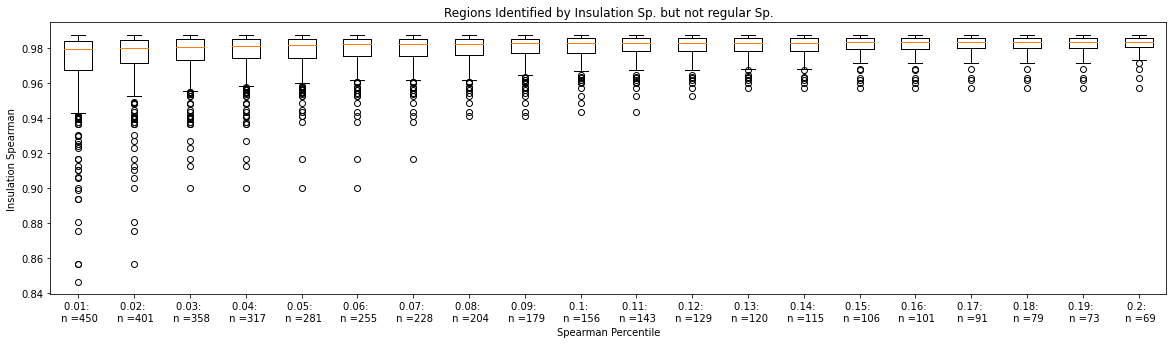

In [122]:
isp_dict = {}
for i in range(20):
    leng = isps[i].shape[0]
    name = str(str(percs[i]) + ': \n n =' + str(leng))
    isp_dict[name] = isps[i]
    
fig, ax = plt.subplots(figsize=(20,5))
ax.boxplot(isp_dict.values())
ax.set_title('Regions Identified by Insulation Sp. but not regular Sp.')
ax.set_xlabel('Spearman Percentile')
ax.set_ylabel('Insulation Spearman')
ax.set_xticklabels(isp_dict.keys());

## Ranked correlation between metrics

In [184]:
comp[['spearman','triangle_spearman', 'insulation_spearman']].corr(method='spearman')

spearman  triangle_spearman  insulation_spearman
spearman             1.000000           0.832428             0.771665
triangle_spearman    0.832428           1.000000             0.784679
insulation_spearman  0.771665           0.784679             1.000000

## PRC and ROC

In [186]:
p, r, prthresh=metrics.precision_recall_curve(comp[str('sp_0.9')], comp[str('tsp_0.9')])

In [189]:
metrics.auc(r,p)

0.9729823937670397

In [248]:
def AUCs_for_one_spearman_thresh(perc_thresh, comp, sThresh):
    tAUROCs = []
    tAUPRCs = []
    tAPs = []
    iAUROCs = []
    iAUPRCs = []
    iAPs = []
    for t in perc_thresh:
        fpr, tpr, thresh =metrics.roc_curve(comp[str('sp_' + str(sThresh))], comp[str('tsp_' + str(t))])
        tAUROCs.append(metrics.auc(fpr,tpr))
        p, r, prthresh=metrics.precision_recall_curve(comp[str('sp_' + str(sThresh))], comp[str('tsp_' + str(t))])
        tAUPRCs.append(metrics.auc(r,p))
        tAPs.append(metrics.average_precision_score(comp[str('sp_' + str(sThresh))], comp[str('tsp_' + str(t))]))
        
        fpr, tpr, thresh =metrics.roc_curve(comp[str('sp_' + str(sThresh))], comp[str('isp_' + str(t))])
        iAUROCs.append(metrics.auc(fpr,tpr))
        p, r, prthresh=metrics.precision_recall_curve(comp[str('sp_' + str(sThresh))], comp[str('isp_' + str(t))])
        iAUPRCs.append(metrics.auc(r,p))
        iAPs.append(metrics.average_precision_score(comp[str('sp_' + str(sThresh))], comp[str('isp_' + str(t))]))
    fig = plt.figure(figsize=(10,5))
    
    
    ax1 = fig.add_subplot(121)
    plt.title(str('ROC; Spearman Quantile Threshold: ' + str(sThresh)))
    ax1.plot(perc_thresh, tAUROCs, c='b', linestyle='solid', label='triangle auROC')
    ax1.plot(perc_thresh, iAUROCs, c='r', linestyle='solid', label='insulation auROC')
    plt.xlabel('Triangle/Insulation Threshold')
    plt.legend(loc='best')
    
    ax2 = fig.add_subplot(122)
    plt.title(str('PRC; Spearman Quantile Threshold: ' + str(sThresh)))
    ax2.plot(perc_thresh, tAUPRCs, c='b', linestyle='dashed', label='triangle auPRC')
    ax2.plot(perc_thresh, tAPs, c='b', linestyle='dotted', label='triangle average precision')
    
    ax2.plot(perc_thresh, iAUPRCs, c='r', linestyle='dashed', label='insulation auPRC')
    ax2.plot(perc_thresh, iAPs, c='r', linestyle='dotted', label='insulation average precision')
    plt.xlabel('Triangle/Insulation Threshold')
    plt.legend(loc='best')
    
    plt.show()
    return

In [249]:
def AUCs_for_set_of_thresh(perc_thresh, comp, alt_thresh):
    for sThresh in perc_thresh:
        if sThresh>0:
            AUCs_for_one_spearman_thresh(alt_thresh, comp, sThresh)

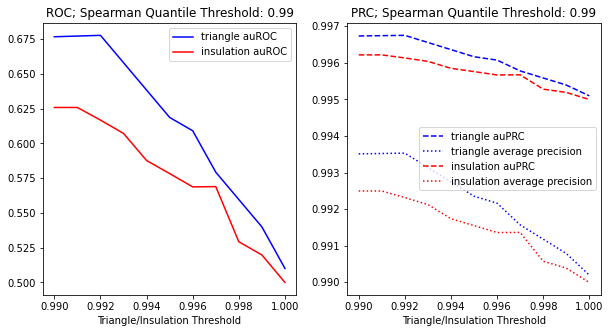

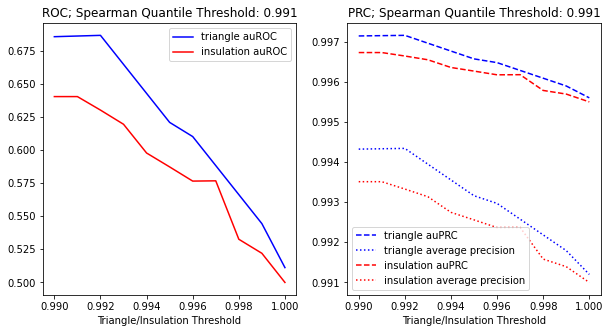

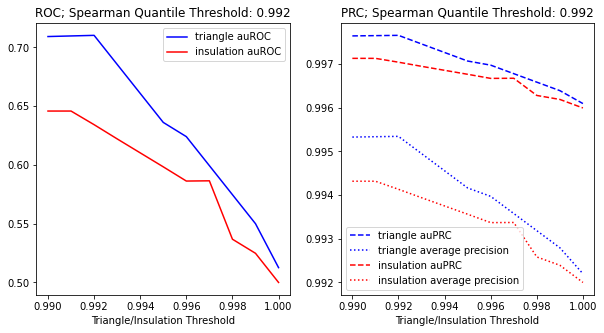

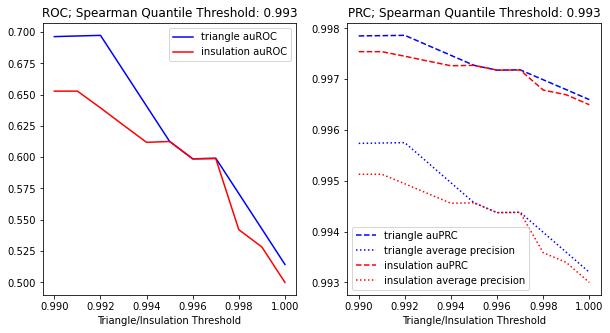

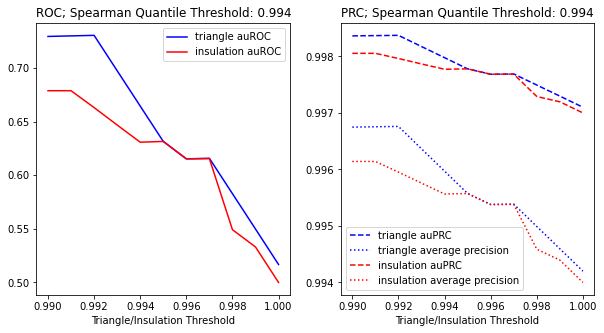

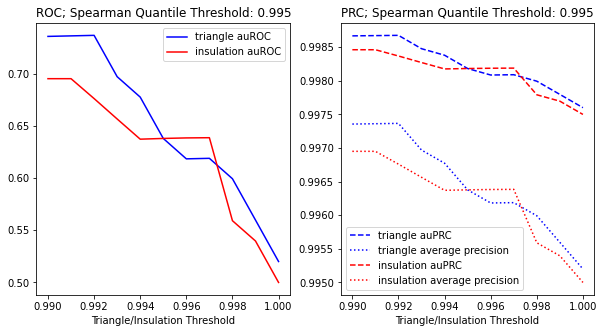

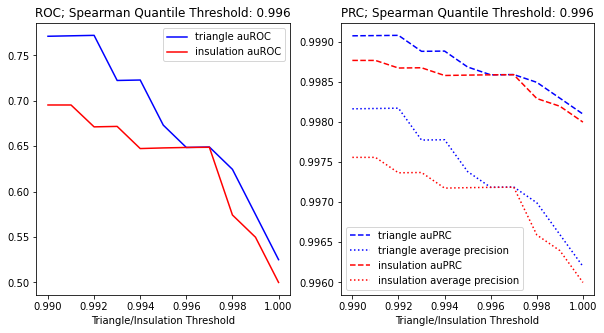

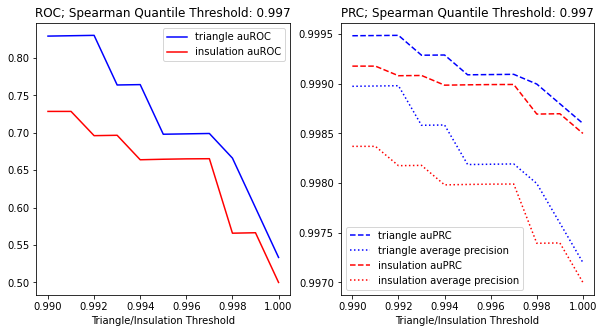

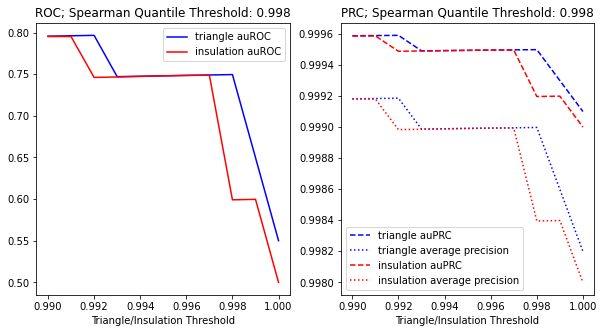

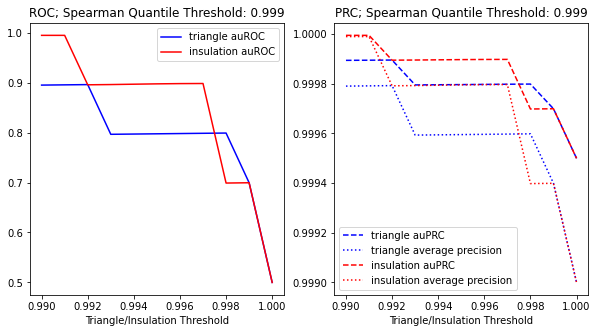

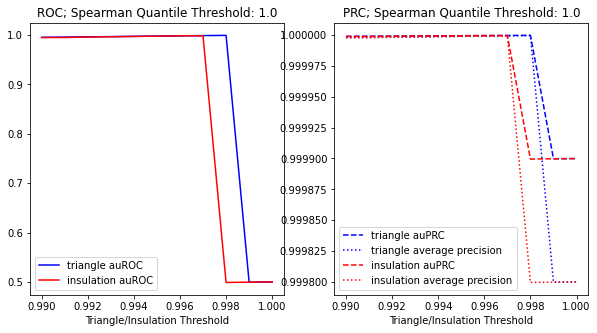

In [274]:
AUCs_for_set_of_thresh(np.arange(0.99, 1.0, 0.001).round(decimals=3), comp,np.arange(0.99, 1.0, 0.001).round(decimals=3))

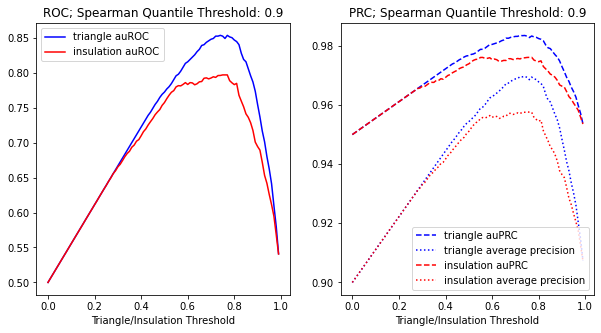

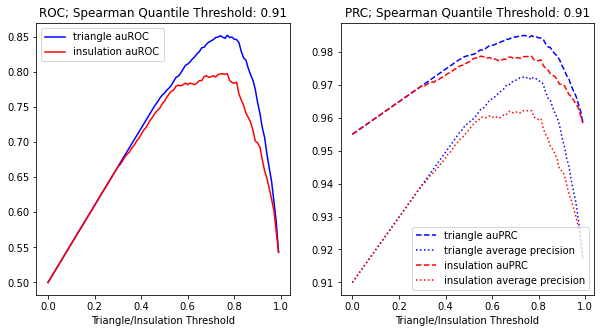

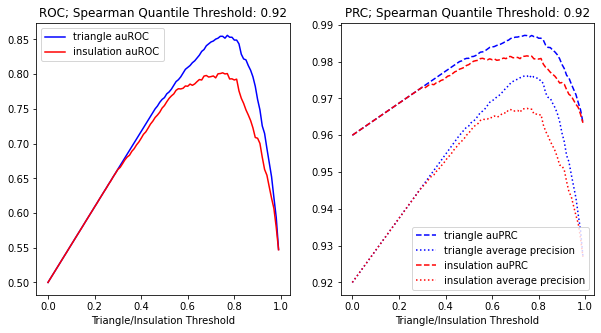

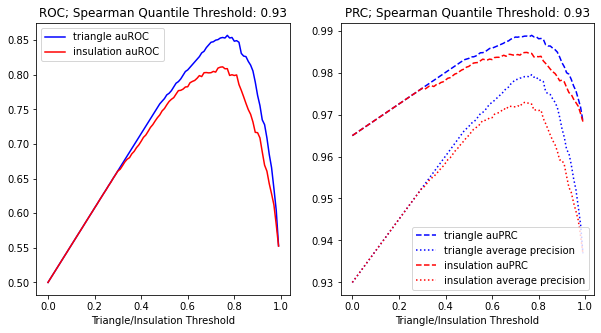

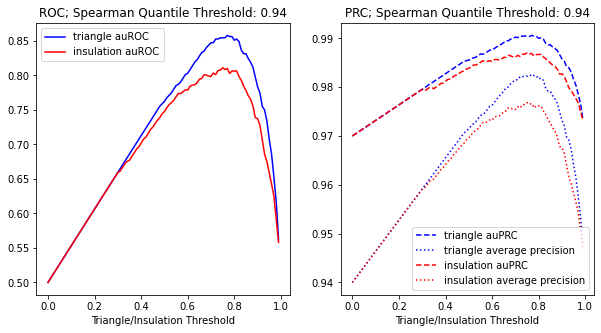

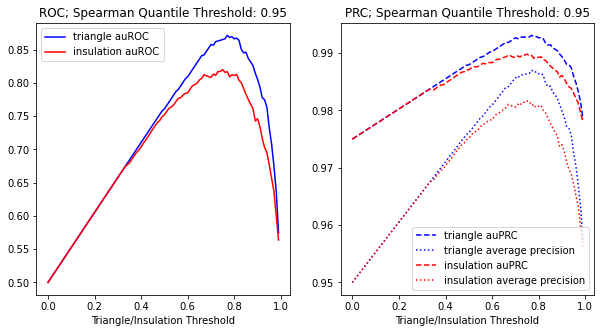

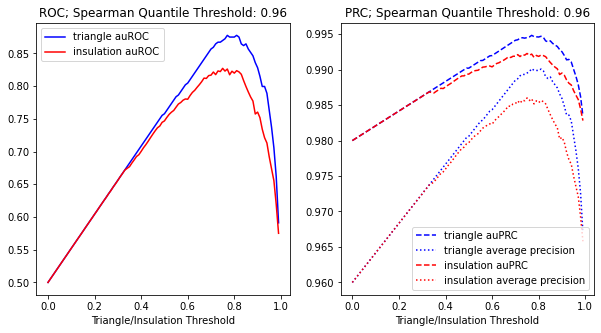

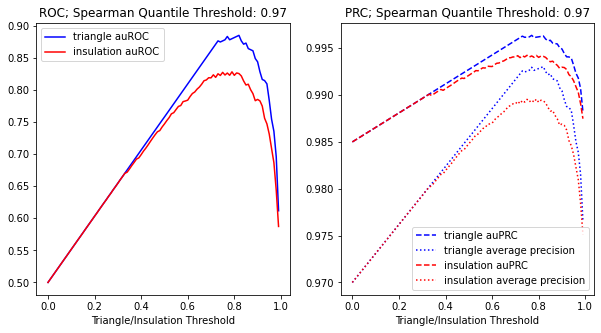

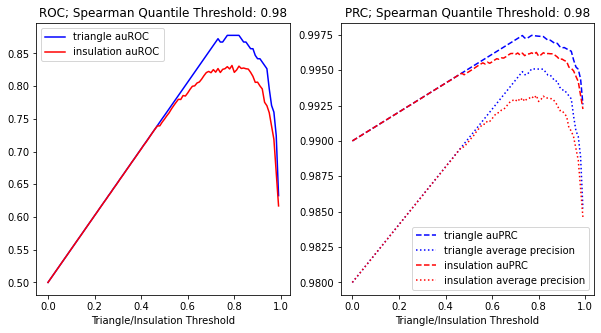

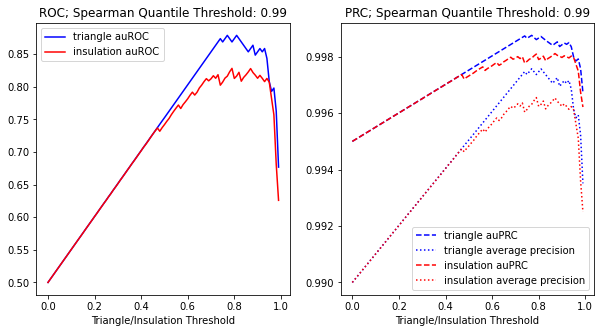

In [250]:
AUCs_for_set_of_thresh(np.arange(0.9, 1.0, 0.01).round(decimals=2), comp,np.arange(0.0, 1.0, 0.010).round(decimals=2))

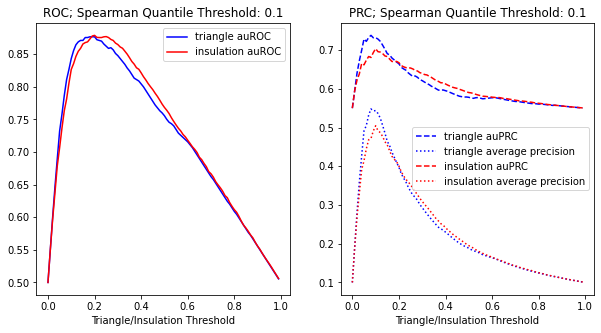

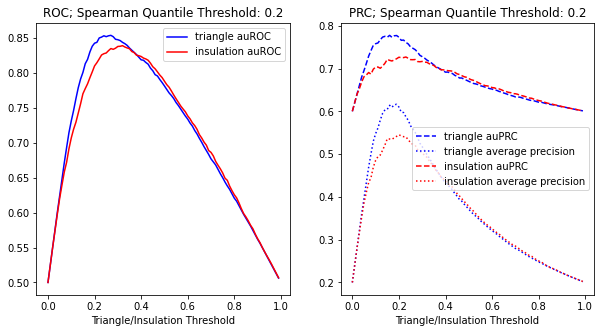

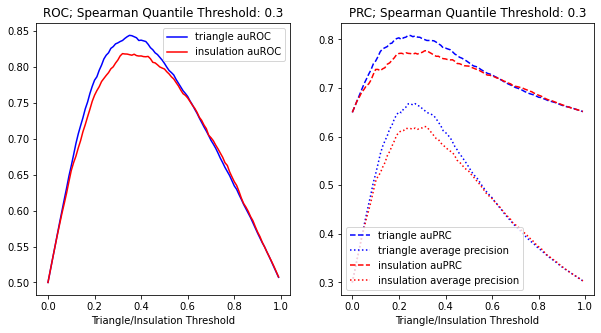

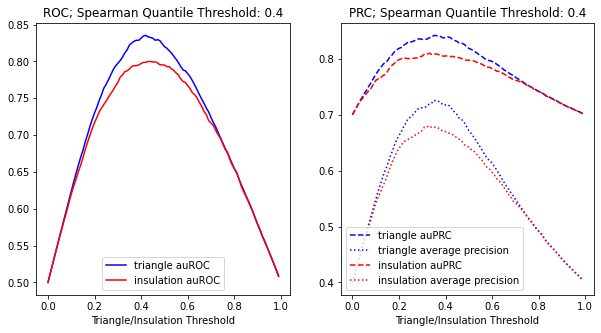

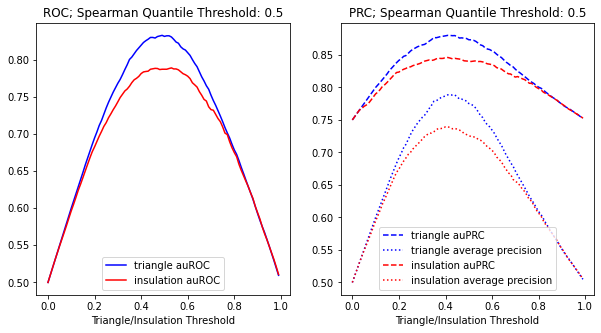

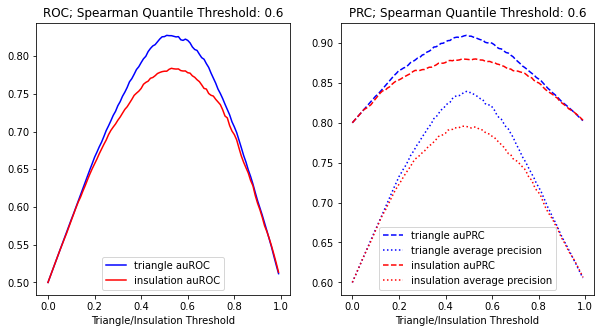

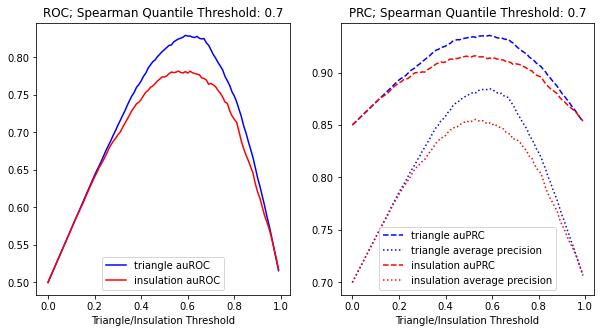

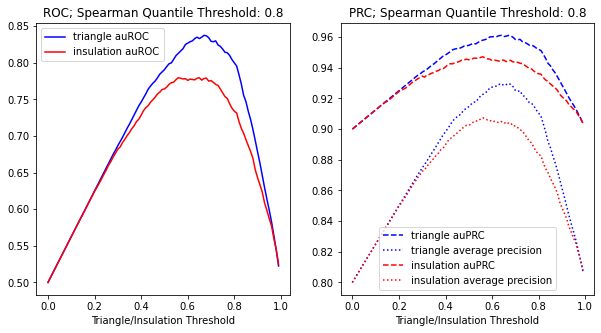

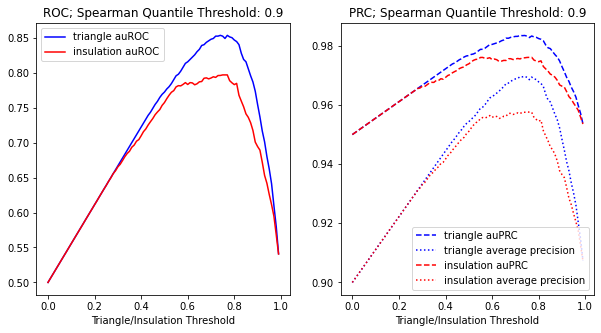

In [251]:
AUCs_for_set_of_thresh(np.arange(0.0, 1.0, 0.1).round(decimals=1), comp,np.arange(0.0, 1.0, 0.010).round(decimals=2))

# Regions called different by numeric threshold (not percentile)

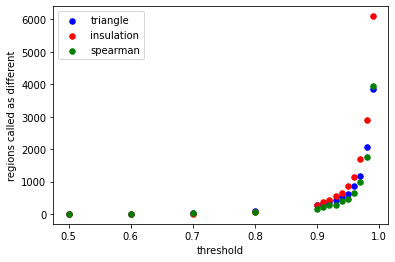

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(thresh, tsp, s=30, c='b', marker="o", label='triangle')
ax1.scatter(thresh, isp, s=30, c='r', marker="o", label='insulation')
ax1.scatter(thresh, sp, s=30, c='g', marker="o", label='spearman')
plt.xlabel('threshold')
plt.ylabel('regions called as different')
plt.legend(loc='upper left');
plt.show()

## Plot Off diagonals

### Triangle vs spearman

In [10]:
diff = find_diff_pairs('AFR_ESN_female_HG03105','altai', 'spearman','triangle_spearman','spearman_triangle_diff')
pos = diff[['chr','windowStartPos']]
tuples = list(zip(pos.chr, pos.windowStartPos))
pos_sets.append(tuples)

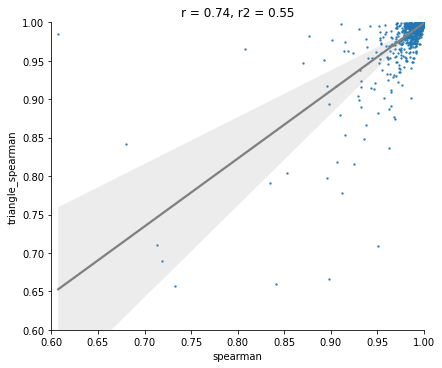

In [12]:
g = sns.lmplot(x='spearman',y='triangle_spearman',data=pairs[('AFR_ESN_female_HG03105','altai')],scatter_kws={'s':2}, line_kws={'color': 'gray'},aspect=1.2)
_ = g.set(xlim=(0.6,1))
_ = g.set(ylim=(0.6,1))
slope, intercept, r, p, se = stats.linregress(pairs[('AFR_ESN_female_HG03105','altai')]['spearman'].values, pairs[('AFR_ESN_female_HG03105','altai')]['triangle_spearman'].values)
_ = plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

<Figure size 576x5760 with 0 Axes>

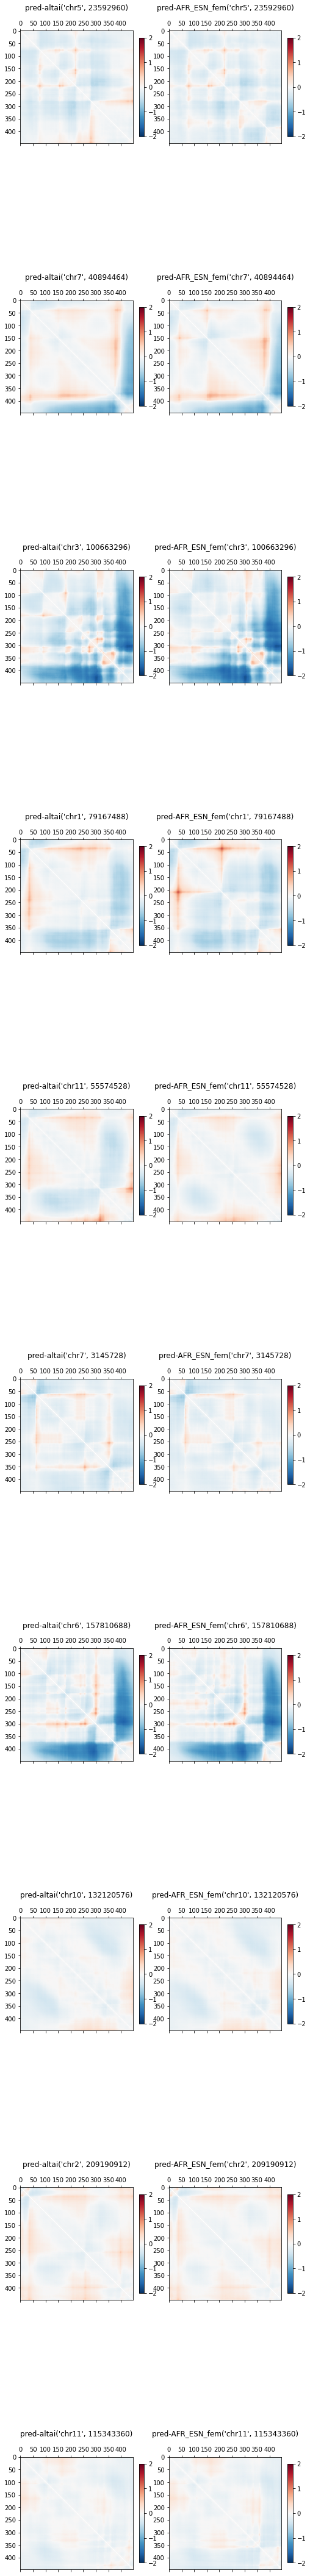

In [13]:
plt.figure(figsize=(8,80))
plot_top_off_diag(altai, AFR_ESN_female_HG03105, tuples, 'altai','AFR_ESN_fem')

### Spearman vs MSE

In [59]:
diff = find_diff_pairs('AFR_ESN_female_HG03105','altai', 'spearman','mse','spearman_mse_diff')
pos = diff[['chr','windowStartPos']]
tuples = list(zip(pos.chr, pos.windowStartPos))
pos_sets.append(tuples)

In [60]:
diff

chr  windowStartPos  spearman       mse  spearman_mse_diff
2267   chr7        71827456  0.999965  0.000011           0.999955
4086  chr16        28835840  0.999967  0.000018           0.999950
4838   chrX        56098816  0.999959  0.000015           0.999944
4087  chr16        29360128  0.999963  0.000022           0.999941
1350   chr4       103809024  0.999945  0.000012           0.999932
550    chr2        95944704  0.999957  0.000030           0.999928
3699  chr13        96993280  0.999944  0.000028           0.999916
3903  chr15        30408704  0.999931  0.000017           0.999914
4961   chrX       131596288  0.999932  0.000020           0.999912
4420  chr18        66060288  0.999926  0.000026           0.999900

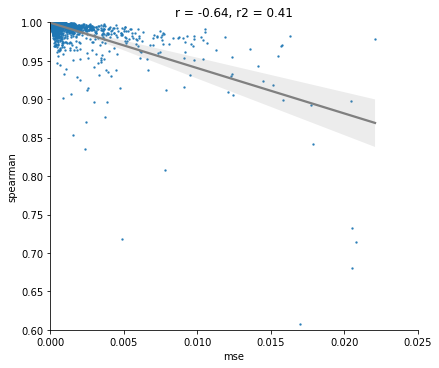

In [32]:
g = sns.lmplot(x='mse',y='spearman',data=pairs[('AFR_ESN_female_HG03105','altai')],scatter_kws={'s':2}, line_kws={'color': 'gray'},aspect=1.2)
_ = g.set(xlim=(0,0.025))
_ = g.set(ylim=(0.6,1))
slope, intercept, r, p, se = stats.linregress(pairs[('AFR_ESN_female_HG03105','altai')]['mse'].values, pairs[('AFR_ESN_female_HG03105','altai')]['spearman'].values)
_ = plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

<Figure size 576x5760 with 0 Axes>

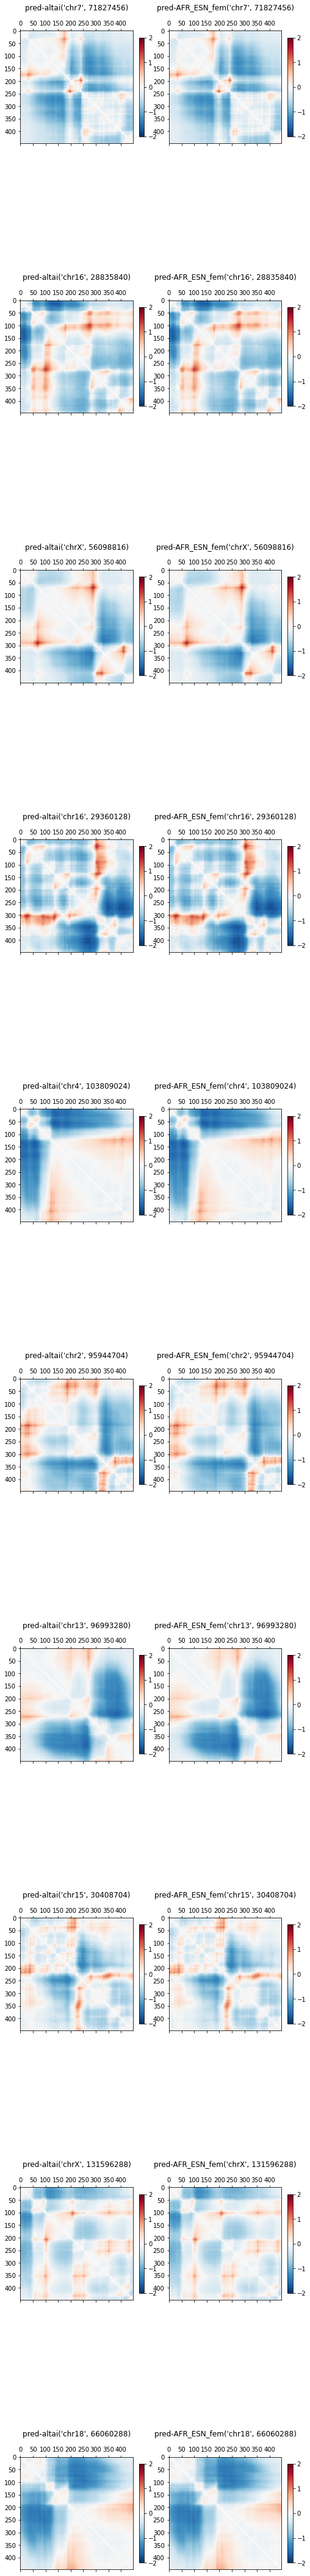

In [13]:
plt.figure(figsize=(8,80))
plot_top_off_diag(altai, AFR_ESN_female_HG03105, tuples, 'altai','AFR_ESN_fem')

### Insulation Spearman vs Spearman

In [61]:
diff = find_diff_pairs('AFR_ESN_female_HG03105','altai', 'insulation_spearman','spearman','insulation_spearman_diff')
pos = diff[['chr','windowStartPos']]
tuples = list(zip(pos.chr, pos.windowStartPos))
pos_sets.append(tuples)

In [62]:
diff

chr  windowStartPos  insulation_spearman  spearman  \
1557   chr5        23592960             0.874086  0.607360   
761    chr2       209190912             0.741834  0.924512   
1866   chr6        14680064             0.761040  0.937441   
1547   chr5        18350080             0.783157  0.948872   
3768  chr14        40370176             0.879205  0.718257   
2148   chr7         3145728             0.945699  0.808146   
1865   chr6        14155776             0.809678  0.937789   
4198  chr17        14155776             0.810636  0.935743   
3480  chr12        90177536             0.807240  0.929218   
1494   chr4       179306496             0.846427  0.968131   

      insulation_spearman_diff  
1557                  0.266726  
761                   0.182678  
1866                  0.176401  
1547                  0.165715  
3768                  0.160948  
2148                  0.137553  
1865                  0.128111  
4198                  0.125108  
3480                  0.121979  
1494                  0.121704

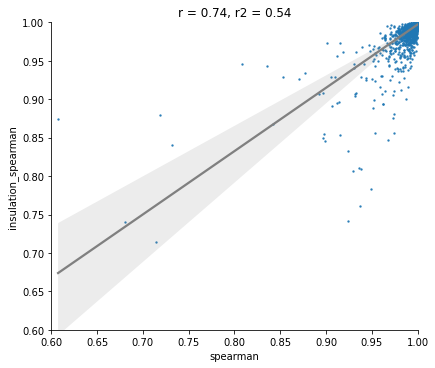

In [33]:
g = sns.lmplot(x='spearman',y='insulation_spearman',data=pairs[('AFR_ESN_female_HG03105','altai')],scatter_kws={'s':2}, line_kws={'color': 'gray'},aspect=1.2)
_ = g.set(xlim=(0.6,1))
_ = g.set(ylim=(0.6,1))
slope, intercept, r, p, se = stats.linregress(pairs[('AFR_ESN_female_HG03105','altai')]['spearman'].values, pairs[('AFR_ESN_female_HG03105','altai')]['insulation_spearman'].values)
_ = plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

<Figure size 576x5760 with 0 Axes>

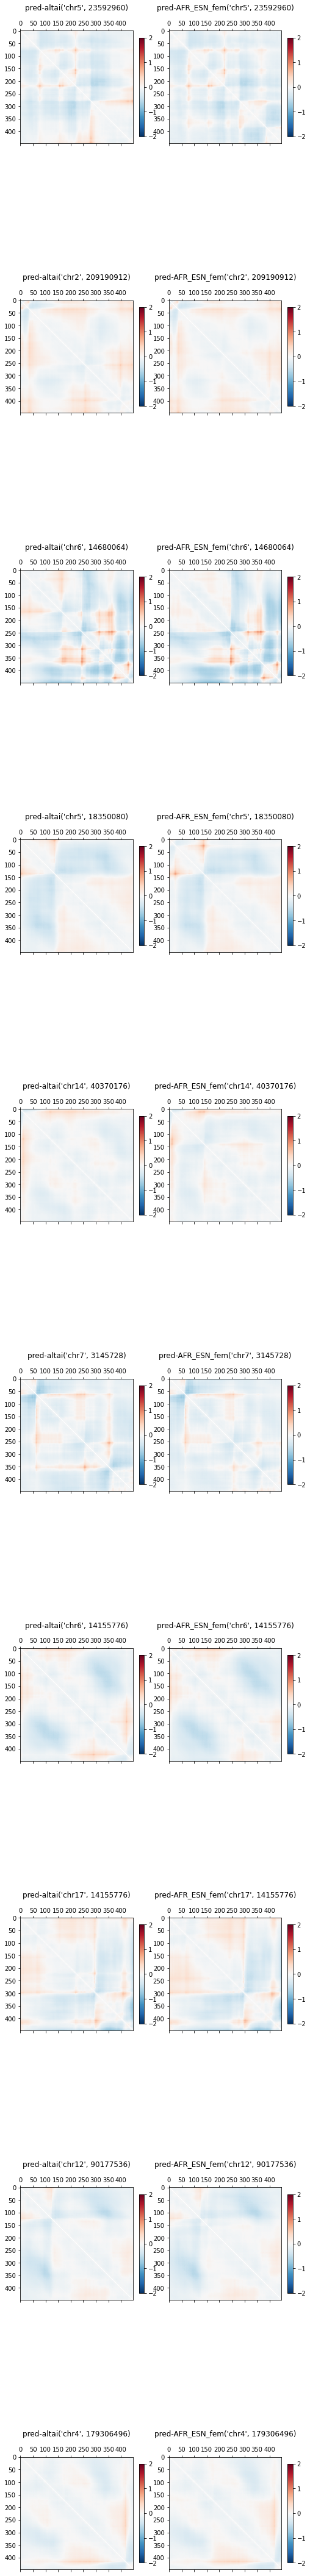

In [15]:
plt.figure(figsize=(8,80))
plot_top_off_diag(altai, AFR_ESN_female_HG03105, tuples, 'altai','AFR_ESN_fem')

### Insulation Spearman vs Triangle Spearman

In [29]:
diff = find_diff_pairs('AFR_ESN_female_HG03105','altai', 'insulation_spearman','triangle_spearman','insulation_triangle_diff')
pos = diff[['chr','windowStartPos']]
tuples = list(zip(pos.chr, pos.windowStartPos))
pos_sets.append(tuples)

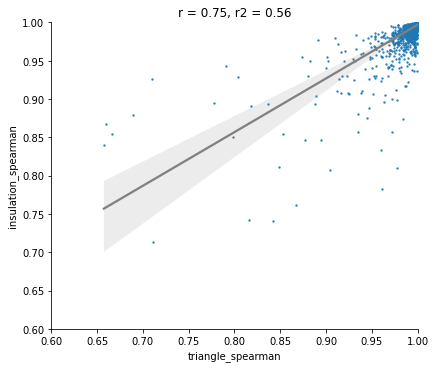

In [34]:
g = sns.lmplot(x='triangle_spearman',y='insulation_spearman',data=pairs[('AFR_ESN_female_HG03105','altai')],scatter_kws={'s':2}, line_kws={'color': 'gray'},aspect=1.2)
_ = g.set(xlim=(0.6,1))
_ = g.set(ylim=(0.6,1))
slope, intercept, r, p, se = stats.linregress(pairs[('AFR_ESN_female_HG03105','altai')]['triangle_spearman'].values, pairs[('AFR_ESN_female_HG03105','altai')]['insulation_spearman'].values)
_ = plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

<Figure size 576x5760 with 0 Axes>

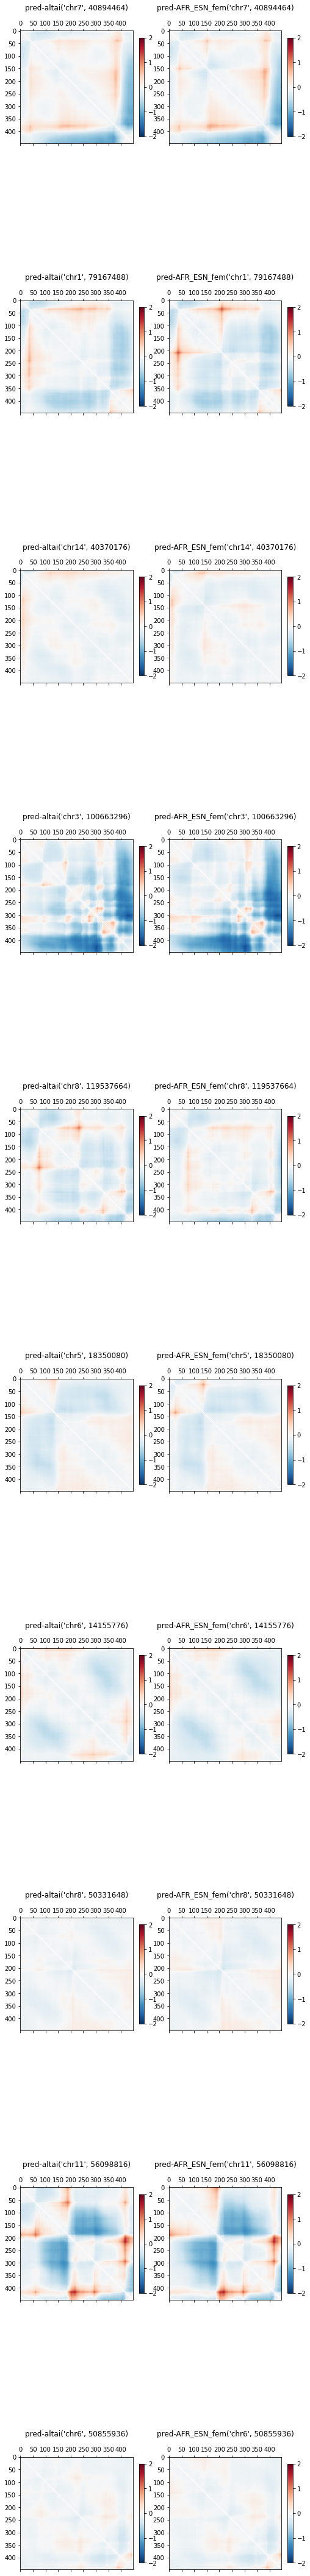

In [17]:
plt.figure(figsize=(8,80))
plot_top_off_diag(altai, AFR_ESN_female_HG03105, tuples, 'altai','AFR_ESN_fem')

## Regions consistenly off diagonal

In [53]:
overlaps=[]
for pair in pos_sets:
    for pair2 in pos_sets:
        if pair != pair2:
            match=list(set(pair) & set(pair2))
            if len(match) != 0:
                overlaps += match
overlaps=list(set(overlaps))
overlaps

[('chr2', 209190912),
 ('chr7', 3145728),
 ('chr7', 40894464),
 ('chr1', 79167488),
 ('chr14', 40370176),
 ('chr6', 14155776),
 ('chr5', 23592960),
 ('chr5', 18350080),
 ('chr3', 100663296)]

In [54]:
len(overlaps)

9

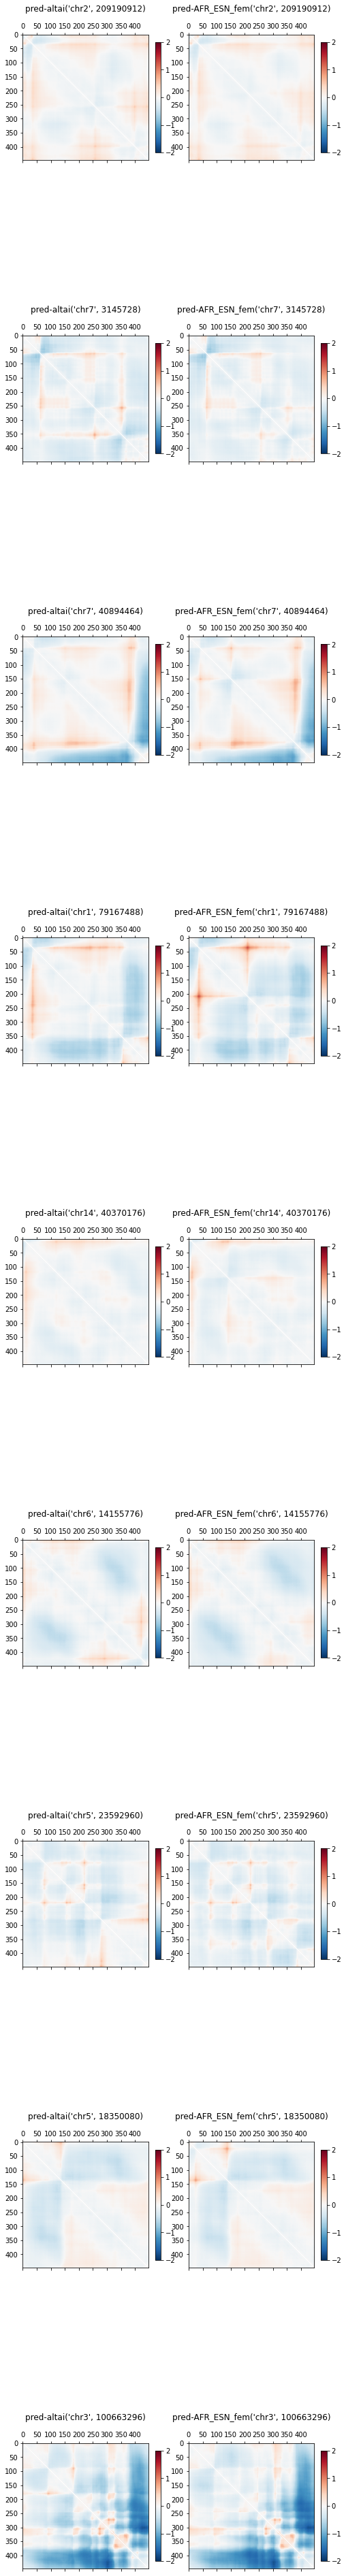

In [56]:
plt.subplots(8,2, figsize=(8,80))
vmin=-2; vmax=2
subplt= np.array([1,2])
for loc in overlaps:
    vec1 = altai.loc[loc]
    vec2 = AFR_ESN_female_HG03105.loc[loc]
    pair_of_plots(vec1, vec2, str('altai' + str(loc)), str( 'AFR_ESN_fem' + str(loc)), subplt)
    subplt += 2